# Smets & Wouters (2007) - Replicacion de Figuras 1 y 2

Este notebook replica las Figuras 1 y 2 del paper "Shocks and Frictions in US Business Cycles: A Bayesian DSGE Approach" (AER, 2007).

**Figura 1**: Forecast Error Variance Decomposition (FEVD)
- Descomposicion de varianza del error de pronostico para GDP growth, Inflation y Interest rate
- Muestra la contribucion de cada shock estructural a diferentes horizontes

**Figura 2**: Impulse Response Functions (IRFs) a shocks de demanda
- Respuestas de Output y Hours worked a shocks de demanda
- Shocks: Risk premium (eb), Government spending (eg), Investment-specific (eqs)

**Requisitos previos:**
- GNU Octave instalado y en PATH
- Dynare instalado
- Archivo `usmodel_mode.mat` con posterior mode

## 1. Setup y Configuracion

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path

# Add parent directory to path
sys.path.append(str(Path.cwd().parent.parent))

from direct_replication import DynareInterface

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("Imports completados")

Imports completados


In [2]:
# Configurar rutas - MODIFICAR SEGUN TU INSTALACION

# Configurar ruta de Octave (necesario en Windows)
os.environ['OCTAVE_EXECUTABLE'] = r'C:\Program Files\GNU Octave\Octave-10.3.0\mingw64\bin\octave-cli.exe'

DYNARE_PATH = r'C:\dynare\6.5\matlab'  # Ruta a carpeta matlab de Dynare
REPO_PATH = Path.cwd().parent.parent / 'repo'  # Carpeta con datos (.xls)
MODEL_PATH = Path.cwd().parent / 'model'  # Carpeta con .mod files

print(f"Octave executable: {os.environ['OCTAVE_EXECUTABLE']}")
print(f"Dynare path: {DYNARE_PATH}")
print(f"Repo path: {REPO_PATH}")
print(f"Model path: {MODEL_PATH}")
print(f"Repo exists: {REPO_PATH.exists()}")
print(f"Model exists: {MODEL_PATH.exists()}")

Octave executable: C:\Program Files\GNU Octave\Octave-10.3.0\mingw64\bin\octave-cli.exe
Dynare path: C:\dynare\6.5\matlab
Repo path: c:\Users\HP\OneDrive\Escritorio\David Guzzi\Github\MECTMT11\repo
Model path: c:\Users\HP\OneDrive\Escritorio\David Guzzi\Github\MECTMT11\direct_replication\model
Repo exists: True
Model exists: True


### Test de Conexion Octave + Dynare

In [3]:
from oct2py import Oct2Py

# Test basico
try:
    oc = Oct2Py()
    result = oc.eval('2 + 2', nout=1)
    print(f"Octave conectado: 2 + 2 = {result}")
    
    # Test Dynare
    oc.addpath(DYNARE_PATH)
    dynare_exists = oc.eval('exist("dynare")', nout=1)
    if dynare_exists == 2:
        print("Dynare encontrado")
    else:
        print("Dynare NO encontrado - verificar DYNARE_PATH")
    
    oc.exit()
    print("\nTodo listo!")
    
except Exception as e:
    print(f"Error: {e}")
    print("Ver setup_instructions.md para solucion de problemas")

Octave conectado: 2 + 2 = 4.0
    _pyeval at line 57 column 10

    _pyeval at line 57 column 10

Dynare encontrado

Todo listo!


## 2. Datos de Referencia del Paper

### Figura 1: Forecast Error Variance Decomposition (FEVD)
Muestra como los 7 shocks estructurales contribuyen a la varianza del error de pronostico en diferentes horizontes para:
- GDP Growth (dy)
- Inflation (pinfobs)
- Interest Rate (robs)

### Figura 2: IRFs a Shocks de Demanda
Muestra las respuestas de Output (y) y Hours (lab) a los 3 shocks de "demanda":
- Risk premium shock (eb)
- Government spending shock (eg)
- Investment-specific shock (eqs)

In [4]:
# Definiciones para las figuras

# Labels para los 7 shocks estructurales
SHOCK_LABELS = {
    'ea': 'Productivity',
    'eb': 'Risk premium',
    'eg': 'Exog. spending',
    'eqs': 'Investment',
    'em': 'Monetary',
    'epinf': 'Price markup',
    'ew': 'Wage markup'
}

SHOCK_ORDER = ['ea', 'eb', 'eg', 'eqs', 'em', 'epinf', 'ew']

# Figura 1: Variables para FEVD
FIGURE1_VARIABLES = ['dy', 'pinfobs', 'robs']
FIGURE1_LABELS = {
    'dy': 'GDP Growth',
    'pinfobs': 'Inflation',
    'robs': 'Federal Funds Rate'
}

# Figura 2: Variables y shocks de demanda (como en el paper)
# 4 graficos: Output, Hours, Inflation, Interest Rate
# Cada grafico muestra 3 lineas (los 3 shocks de demanda)
DEMAND_SHOCKS = ['eb', 'eg', 'eqs']
FIGURE2_VARIABLES = ['y', 'lab', 'pinfobs', 'robs']
FIGURE2_LABELS = {
    'y': 'Output',
    'lab': 'Hours',
    'pinfobs': 'Inflation',
    'robs': 'Interest Rate'
}

print("Configuracion de figuras definida")
print(f"\nFigura 1 - FEVD para: {FIGURE1_VARIABLES}")
print(f"Figura 2 - IRFs de {FIGURE2_VARIABLES} a shocks: {DEMAND_SHOCKS}")

Configuracion de figuras definida

Figura 1 - FEVD para: ['dy', 'pinfobs', 'robs']
Figura 2 - IRFs de ['y', 'lab', 'pinfobs', 'robs'] a shocks: ['eb', 'eg', 'eqs']


## 3. Ejecutar Dynare con Modelo Modificado

Usamos `usmodel_figures.mod` que tiene el comando `stoch_simul` modificado para generar:
- Conditional Variance Decomposition (FEVD) para horizontes 1-40
- IRFs para variables adicionales (y, lab)

In [5]:
# Inicializar interfaz Dynare
di = DynareInterface(DYNARE_PATH, str(MODEL_PATH))

print("Interfaz Dynare inicializada")

    _pyeval at line 57 column 10

    _pyeval at line 57 column 10

    _pyeval at line 57 column 10

Interfaz Dynare inicializada


In [6]:
# Ejecutar modelo modificado para figuras
# Este modelo incluye conditional_variance_decomposition y variables adicionales

print("Ejecutando usmodel_figures.mod...")
print("(Esto puede tardar varios minutos)\n")

di.run_model('usmodel_figures.mod')

print("\nDynare completado")

Ejecutando usmodel_figures.mod...
(Esto puede tardar varios minutos)


Step 1: Closing Octave session to release file locks...
Waiting for Windows to release file handles...

Step 2: Cleaning up directories...
Searching for directories to clean up...
Adding model directory to cleanup: usmodel_figures/
Found 1 directory(ies): ['usmodel_figures']
✓ Cleaned up directory: usmodel_figures

Step 3: Starting fresh Octave session...
    _pyeval at line 57 column 10

    _pyeval at line 57 column 10

    _pyeval at line 57 column 10

✓ Octave session ready

Step 4: Running Dynare estimation...
Command: dynare usmodel_figures nograph
(This may take several minutes...)

Starting Dynare (version 6.5).
Calling Dynare with arguments: nograph
Starting preprocessing of the model file ...
Found 40 equation(s).
Evaluating expressions...
Computing static model derivatives (order 1).
Normalizing the static model...
Finding the optimal block decomposition of the static model...
11 block(s) found:
  9 recur

## 4. Extraer FEVD para Figura 1

La Conditional Variance Decomposition muestra como cada shock contribuye a la varianza del error de pronostico en diferentes horizontes.

In [7]:
def extract_fevd(di, max_horizon=40):
    """
    Extrae la Conditional Variance Decomposition de Dynare 6.x.
    
    En Dynare 6.x, oo_.conditional_variance_decomposition tiene dimensiones:
    (n_vars x n_horizons x n_shocks)
    
    Returns:
        DataFrame con columnas: horizon, variable, shock, variance_share (en %)
    """
    # Verificar que existe
    has_fevd = di.oc.eval('isfield(oo_, "conditional_variance_decomposition")', nout=1)
    if not has_fevd:
        raise RuntimeError("FEVD no encontrada. Verificar stoch_simul con conditional_variance_decomposition.")
    
    # Obtener dimensiones del array
    fevd_size = di.oc.eval('size(oo_.conditional_variance_decomposition)', nout=1)
    fevd_size = np.array(fevd_size).flatten()
    
    # En Dynare 6.x: (n_vars x n_horizons x n_shocks)
    n_vars = int(fevd_size[0])
    n_horizons = int(fevd_size[1])
    n_shocks = int(fevd_size[2])
    
    print(f"FEVD dimensions: {n_vars} variables x {n_horizons} horizons x {n_shocks} shocks")
    
    # Variables del stoch_simul (orden del comando en .mod file)
    stoch_vars = ['dy', 'pinfobs', 'robs', 'y', 'lab', 'labobs']
    var_names = stoch_vars[:n_vars]
    
    # Nombres de shocks (orden del varexo en .mod file)
    # Hardcodeados para evitar problemas de formato con oct2py
    shock_names = ['ea', 'eb', 'eg', 'eqs', 'em', 'epinf', 'ew']
    
    print(f"Variables: {var_names}")
    print(f"Shocks: {shock_names}")
    
    # Extraer array FEVD
    fevd_array = di.oc.eval('oo_.conditional_variance_decomposition', nout=1)
    print(f"FEVD array shape: {fevd_array.shape}")
    
    # Convertir a DataFrame
    # Acceso: fevd_array[var, horizon, shock] - valores en escala 0-1, convertir a %
    data = []
    for h in range(min(n_horizons, max_horizon)):
        for v in range(n_vars):
            for s in range(n_shocks):
                # Multiplicar por 100 para convertir a porcentaje
                value = fevd_array[v, h, s] * 100
                data.append({
                    'horizon': h + 1,
                    'variable': var_names[v],
                    'shock': shock_names[s],
                    'variance_share': float(value)
                })
    
    return pd.DataFrame(data)

# Extraer FEVD
print("Extrayendo FEVD...\n")
fevd_df = extract_fevd(di, max_horizon=40)

print(f"\nFEVD extraida: {len(fevd_df)} filas")

# Verificar suma para primeras variables/horizontes
print("\nVerificacion rapida (debe sumar ~100%):")
for var in ['dy', 'pinfobs', 'robs']:
    for h in [1, 10, 40]:
        total = fevd_df[(fevd_df['variable']==var) & (fevd_df['horizon']==h)]['variance_share'].sum()
        print(f"  {var} h={h}: {total:.1f}%")

# Mostrar primeras filas para verificar formato
print("\nPrimeras filas:")
fevd_df.head(10)

Extrayendo FEVD...



FEVD dimensions: 6 variables x 100 horizons x 7 shocks
Variables: ['dy', 'pinfobs', 'robs', 'y', 'lab', 'labobs']
Shocks: ['ea', 'eb', 'eg', 'eqs', 'em', 'epinf', 'ew']
FEVD array shape: (6, 100, 7)

FEVD extraida: 1680 filas

Verificacion rapida (debe sumar ~100%):
  dy h=1: 100.0%
  dy h=10: 100.0%
  dy h=40: 100.0%
  pinfobs h=1: 100.0%
  pinfobs h=10: 100.0%
  pinfobs h=40: 100.0%
  robs h=1: 100.0%
  robs h=10: 100.0%
  robs h=40: 100.0%

Primeras filas:


,horizon,variable,shock,variance_share
0,1,dy,ea,15.038187
1,1,dy,eb,24.408920
2,1,dy,eg,34.431538
3,1,dy,eqs,18.966793
4,1,dy,em,5.145230
5,1,dy,epinf,1.912627
6,1,dy,ew,0.096705
7,1,pinfobs,ea,3.506721
8,1,pinfobs,eb,0.396635
9,1,pinfobs,eg,0.252804


In [8]:
# Verificar que FEVD suma 100% para cada (variable, horizonte)
print("Verificando que FEVD suma 100% para cada variable y horizonte...\n")

for var in FIGURE1_VARIABLES:
    var_data = fevd_df[fevd_df['variable'] == var]
    for h in [1, 4, 8, 20, 40]:
        h_data = var_data[var_data['horizon'] == h]
        total = h_data['variance_share'].sum()
        status = "OK" if abs(total - 100) < 0.5 else "WARNING"
        print(f"  {var} h={h}: {total:.2f}% [{status}]")

print("\nVerificacion completada")

Verificando que FEVD suma 100% para cada variable y horizonte...

  dy h=1: 100.00% [OK]
  dy h=4: 100.00% [OK]
  dy h=8: 100.00% [OK]
  dy h=20: 100.00% [OK]
  dy h=40: 100.00% [OK]
  pinfobs h=1: 100.00% [OK]
  pinfobs h=4: 100.00% [OK]
  pinfobs h=8: 100.00% [OK]
  pinfobs h=20: 100.00% [OK]
  pinfobs h=40: 100.00% [OK]
  robs h=1: 100.00% [OK]
  robs h=4: 100.00% [OK]
  robs h=8: 100.00% [OK]
  robs h=20: 100.00% [OK]
  robs h=40: 100.00% [OK]

Verificacion completada


## 5. Extraer IRFs para Figura 2

Extraemos las IRFs de Output (y) y Hours (lab) a los shocks de demanda.

In [9]:
# Extraer IRFs
print("Extrayendo IRFs...\n")

irfs_df = di.get_irfs(periods=20)

print(f"IRFs extraidas: {len(irfs_df)} observaciones")
print(f"\nVariables disponibles: {irfs_df['variable'].unique()}")
print(f"Shocks disponibles: {irfs_df['shock'].unique()}")

irfs_df.head(10)

Extrayendo IRFs...



IRFs extraidas: 840 observaciones

Variables disponibles: ['dy' 'pinfobs' 'robs' 'y' 'lab' 'labobs']
Shocks disponibles: ['ea' 'eb' 'eg' 'eqs' 'em' 'epinf' 'ew']


,variable,shock,period,value
0,dy,ea,0,0.328814
1,dy,ea,1,0.108726
2,dy,ea,2,0.086822
3,dy,ea,3,0.065252
4,dy,ea,4,0.045993
5,dy,ea,5,0.029734
6,dy,ea,6,0.016481
7,dy,ea,7,0.005942
8,dy,ea,8,-0.002267
9,dy,ea,9,-0.008531


In [10]:
# Filtrar IRFs para Figura 2
figure2_irfs = irfs_df[
    (irfs_df['variable'].isin(FIGURE2_VARIABLES)) & 
    (irfs_df['shock'].isin(DEMAND_SHOCKS))
].copy()

print(f"IRFs para Figura 2: {len(figure2_irfs)} observaciones")
print(f"\nVariables: {figure2_irfs['variable'].unique()}")
print(f"Shocks: {figure2_irfs['shock'].unique()}")

figure2_irfs.head()

IRFs para Figura 2: 240 observaciones

Variables: ['pinfobs' 'robs' 'y' 'lab']
Shocks: ['eb' 'eg' 'eqs']


,variable,shock,period,value
140,pinfobs,eb,0,0.018047
141,pinfobs,eb,1,0.020446
142,pinfobs,eb,2,0.018990
143,pinfobs,eb,3,0.016686
144,pinfobs,eb,4,0.014310


## 6. Graficar Figura 1: FEVD

Creamos un grafico de areas apiladas (stacked area chart) para cada variable, mostrando la contribucion de cada shock a la varianza del error de pronostico.

Generando Figura 1: FEVD (barras apiladas)...



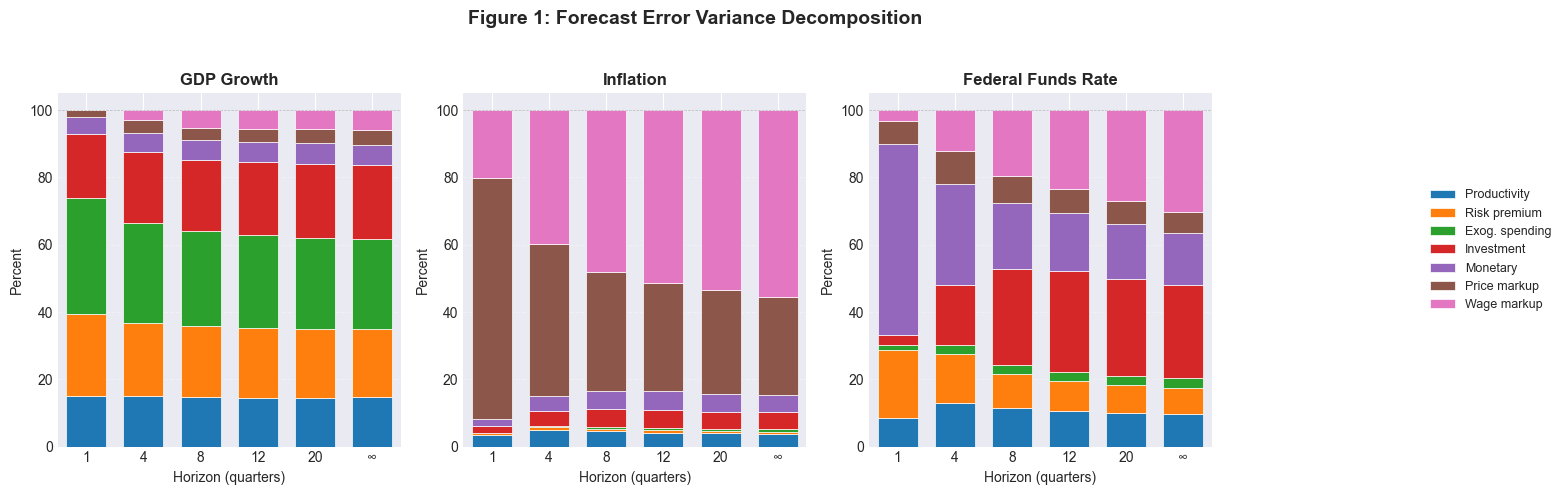


Figura 1 generada


In [11]:
def plot_figure1_fevd(fevd_df, variables, shock_order, shock_labels, var_labels):
    """
    Grafica Figura 1: FEVD como barras apiladas (estilo paper S&W 2007).
    
    El paper original muestra barras apiladas para horizontes seleccionados:
    1, 4, 8, 12, 20 quarters y "infinito" (usamos 40 como proxy)
    """
    # Horizontes a mostrar (como en el paper)
    horizons_to_plot = [1, 4, 8, 12, 20, 40]
    horizon_labels = ['1', '4', '8', '12', '20', '∞']
    
    fig, axes = plt.subplots(1, 3, figsize=(14, 5))
    
    # Colores distintivos para los 7 shocks
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
    
    bar_width = 0.7
    
    for idx, var in enumerate(variables):
        ax = axes[idx]
        
        # Filtrar datos para esta variable y horizontes seleccionados
        var_data = fevd_df[
            (fevd_df['variable'] == var) & 
            (fevd_df['horizon'].isin(horizons_to_plot))
        ].copy()
        
        if len(var_data) == 0:
            ax.set_title(f"{var_labels.get(var, var)} - NO DATA")
            continue
        
        # Preparar datos para barras apiladas
        x_positions = np.arange(len(horizons_to_plot))
        bottom = np.zeros(len(horizons_to_plot))
        
        for s_idx, shock in enumerate(shock_order):
            heights = []
            for h in horizons_to_plot:
                val = var_data[(var_data['horizon'] == h) & (var_data['shock'] == shock)]['variance_share']
                heights.append(val.values[0] if len(val) > 0 else 0)
            
            ax.bar(x_positions, heights, bar_width, bottom=bottom, 
                   label=shock_labels.get(shock, shock), color=colors[s_idx], 
                   edgecolor='white', linewidth=0.5)
            bottom += np.array(heights)
        
        ax.set_title(var_labels.get(var, var), fontsize=12, fontweight='bold')
        ax.set_xlabel('Horizon (quarters)', fontsize=10)
        ax.set_ylabel('Percent', fontsize=10)
        ax.set_xticks(x_positions)
        ax.set_xticklabels(horizon_labels)
        ax.set_ylim(0, 105)
        ax.set_xlim(-0.5, len(horizons_to_plot) - 0.5)
        
        # Linea horizontal en 100%
        ax.axhline(100, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
        
        # Grid horizontal
        ax.yaxis.grid(True, alpha=0.3, linestyle='--')
        ax.set_axisbelow(True)
    
    # Leyenda comun fuera de los graficos
    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.12, 0.5), fontsize=9)
    
    plt.suptitle('Figure 1: Forecast Error Variance Decomposition', fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 0.88, 0.95])
    
    return fig

# Graficar Figura 1
print("Generando Figura 1: FEVD (barras apiladas)...\n")

fig1 = plot_figure1_fevd(
    fevd_df, 
    FIGURE1_VARIABLES, 
    SHOCK_ORDER, 
    SHOCK_LABELS, 
    FIGURE1_LABELS
)

plt.show()
print("\nFigura 1 generada")

## 7. Graficar Figura 2: IRFs a Shocks de Demanda

Creamos un grid 2x3 mostrando las respuestas de Output y Hours a los 3 shocks de demanda.

Generando Figura 2: IRFs a shocks de demanda...



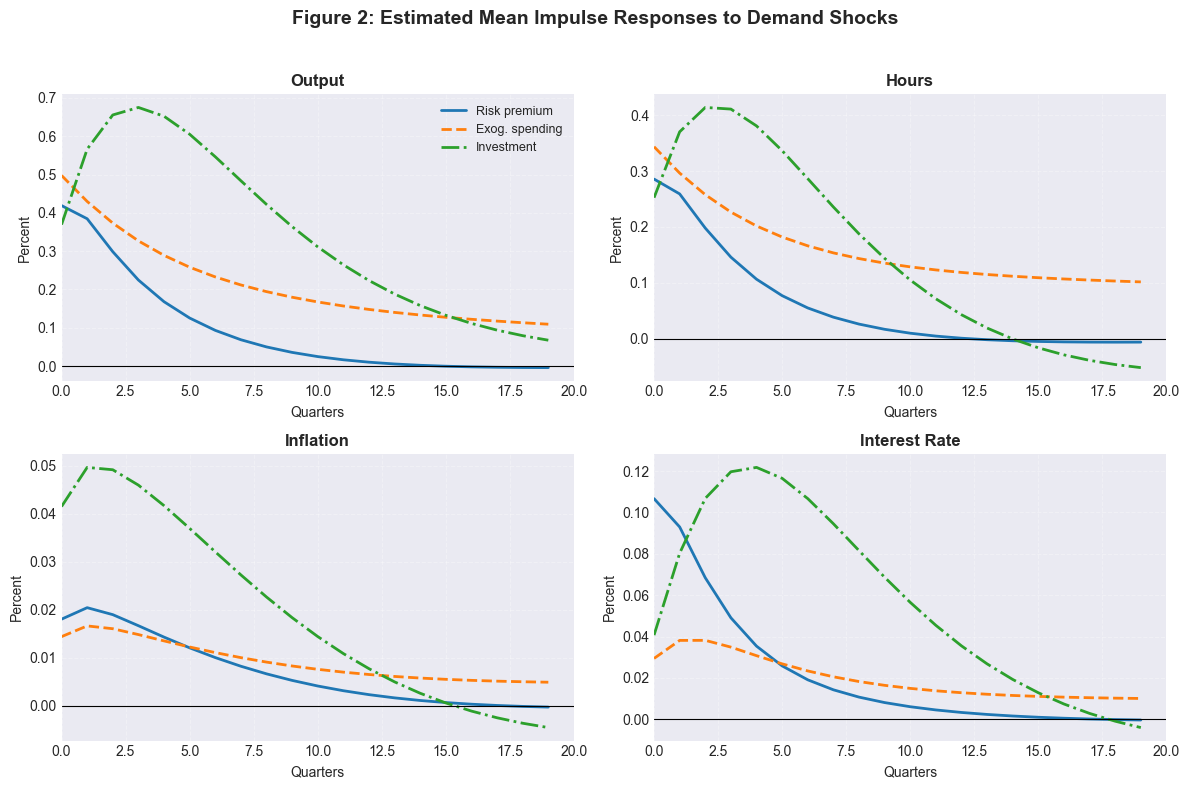


Figura 2 generada


In [12]:
def plot_figure2_irfs(irfs_df, variables, shocks, shock_labels, var_labels):
    """
    Grafica Figura 2: IRFs a shocks de demanda (estilo paper S&W 2007).
    
    Layout del paper:
    - 4 graficos en grid 2x2: Output, Hours, Inflation, Interest Rate
    - Cada grafico muestra 3 lineas: Risk premium, Gov spending, Investment
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()  # Para iterar facilmente
    
    # Colores y estilos para los 3 shocks de demanda
    shock_styles = {
        'eb': {'color': '#1f77b4', 'linestyle': '-', 'label': 'Risk premium'},
        'eg': {'color': '#ff7f0e', 'linestyle': '--', 'label': 'Exog. spending'},
        'eqs': {'color': '#2ca02c', 'linestyle': '-.', 'label': 'Investment'}
    }
    
    for idx, var in enumerate(variables):
        ax = axes[idx]
        
        for shock in shocks:
            # Filtrar datos para esta variable y shock
            irf_data = irfs_df[
                (irfs_df['variable'] == var) & 
                (irfs_df['shock'] == shock)
            ].sort_values('period')
            
            if len(irf_data) > 0:
                style = shock_styles.get(shock, {'color': 'gray', 'linestyle': '-'})
                ax.plot(irf_data['period'], irf_data['value'], 
                       color=style['color'], 
                       linestyle=style['linestyle'],
                       linewidth=2,
                       label=style.get('label', shock_labels.get(shock, shock)))
        
        # Linea de referencia en y=0
        ax.axhline(0, color='k', linestyle='-', linewidth=0.8)
        
        # Titulo del subplot
        ax.set_title(var_labels.get(var, var), fontsize=12, fontweight='bold')
        ax.set_xlabel('Quarters', fontsize=10)
        ax.set_ylabel('Percent', fontsize=10)
        
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.set_xlim(0, 20)
        
        # Leyenda solo en el primer grafico
        if idx == 0:
            ax.legend(loc='upper right', fontsize=9)
    
    plt.suptitle('Figure 2: Estimated Mean Impulse Responses to Demand Shocks', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    return fig

# Graficar Figura 2
print("Generando Figura 2: IRFs a shocks de demanda...\n")

fig2 = plot_figure2_irfs(
    figure2_irfs,
    FIGURE2_VARIABLES,
    DEMAND_SHOCKS,
    SHOCK_LABELS,
    FIGURE2_LABELS
)

plt.show()
print("\nFigura 2 generada")

## 8. Exportar Resultados

In [13]:
# Guardar figuras
output_dir = Path.cwd()

fig1.savefig(output_dir / 'figure1_fevd.png', dpi=300, bbox_inches='tight')
print(f"Figura 1 guardada en: {output_dir / 'figure1_fevd.png'}")

fig2.savefig(output_dir / 'figure2_irfs.png', dpi=300, bbox_inches='tight')
print(f"Figura 2 guardada en: {output_dir / 'figure2_irfs.png'}")

# Guardar datos en CSV
fevd_figure1 = fevd_df[fevd_df['variable'].isin(FIGURE1_VARIABLES)]
fevd_figure1.to_csv(output_dir / 'figure1_fevd_data.csv', index=False)
print(f"\nDatos FEVD guardados en: {output_dir / 'figure1_fevd_data.csv'}")

figure2_irfs.to_csv(output_dir / 'figure2_irfs_data.csv', index=False)
print(f"Datos IRFs guardados en: {output_dir / 'figure2_irfs_data.csv'}")

Figura 1 guardada en: c:\Users\HP\OneDrive\Escritorio\David Guzzi\Github\MECTMT11\direct_replication\notebooks\figure1_fevd.png
Figura 2 guardada en: c:\Users\HP\OneDrive\Escritorio\David Guzzi\Github\MECTMT11\direct_replication\notebooks\figure2_irfs.png

Datos FEVD guardados en: c:\Users\HP\OneDrive\Escritorio\David Guzzi\Github\MECTMT11\direct_replication\notebooks\figure1_fevd_data.csv
Datos IRFs guardados en: c:\Users\HP\OneDrive\Escritorio\David Guzzi\Github\MECTMT11\direct_replication\notebooks\figure2_irfs_data.csv


## 9. Resumen de Resultados

In [14]:
# Resumen FEVD en horizontes clave
print("="*70)
print("RESUMEN: FEVD en horizontes seleccionados")
print("="*70)

for var in FIGURE1_VARIABLES:
    print(f"\n{FIGURE1_LABELS[var]}:")
    print("-" * 50)
    
    var_data = fevd_df[fevd_df['variable'] == var]
    
    for h in [1, 4, 10, 40]:
        h_data = var_data[var_data['horizon'] == h]
        print(f"  Horizon {h:2d}:  ", end="")
        for shock in SHOCK_ORDER:
            share = h_data[h_data['shock'] == shock]['variance_share'].values
            if len(share) > 0:
                print(f"{shock}={share[0]:5.1f}%  ", end="")
        print()

RESUMEN: FEVD en horizontes seleccionados

GDP Growth:
--------------------------------------------------
  Horizon  1:  ea= 15.0%  eb= 24.4%  eg= 34.4%  eqs= 19.0%  em=  5.1%  epinf=  1.9%  ew=  0.1%  
  Horizon  4:  ea= 15.1%  eb= 21.8%  eg= 29.6%  eqs= 21.1%  em=  5.8%  epinf=  3.7%  ew=  3.0%  
  Horizon 10:  ea= 14.4%  eb= 21.0%  eg= 27.9%  eqs= 21.4%  em=  6.0%  epinf=  3.8%  ew=  5.5%  
  Horizon 40:  ea= 14.7%  eb= 20.2%  eg= 26.9%  eqs= 21.7%  em=  6.1%  epinf=  4.4%  ew=  5.9%  

Inflation:
--------------------------------------------------
  Horizon  1:  ea=  3.5%  eb=  0.4%  eg=  0.3%  eqs=  2.1%  em=  2.0%  epinf= 71.6%  ew= 20.2%  
  Horizon  4:  ea=  5.0%  eb=  0.7%  eg=  0.5%  eqs=  4.5%  em=  4.4%  epinf= 45.0%  ew= 39.9%  
  Horizon 10:  ea=  4.3%  eb=  0.7%  eg=  0.6%  eqs=  5.4%  em=  5.5%  epinf= 33.4%  ew= 50.0%  
  Horizon 40:  ea=  3.8%  eb=  0.6%  eg=  0.8%  eqs=  5.0%  em=  5.1%  epinf= 29.1%  ew= 55.6%  

Federal Funds Rate:
----------------------------------

In [15]:
# Resumen IRFs - valores en impacto y pico
print("\n" + "="*70)
print("RESUMEN: IRFs a shocks de demanda")
print("="*70)

for var in FIGURE2_VARIABLES:
    print(f"\n{FIGURE2_LABELS[var]}:")
    print("-" * 50)
    
    for shock in DEMAND_SHOCKS:
        irf_data = figure2_irfs[
            (figure2_irfs['variable'] == var) & 
            (figure2_irfs['shock'] == shock)
        ].sort_values('period')
        
        if len(irf_data) > 0:
            impact = irf_data[irf_data['period'] == 0]['value'].values[0]
            peak_idx = irf_data['value'].abs().idxmax()
            peak_period = irf_data.loc[peak_idx, 'period']
            peak_value = irf_data.loc[peak_idx, 'value']
            
            print(f"  {SHOCK_LABELS[shock]:15s}: Impact={impact:+.4f}, Peak={peak_value:+.4f} (t={int(peak_period)})")


RESUMEN: IRFs a shocks de demanda

Output:
--------------------------------------------------
  Risk premium   : Impact=+0.4189, Peak=+0.4189 (t=0)
  Exog. spending : Impact=+0.4975, Peak=+0.4975 (t=0)
  Investment     : Impact=+0.3693, Peak=+0.6750 (t=3)

Hours:
--------------------------------------------------
  Risk premium   : Impact=+0.2858, Peak=+0.2858 (t=0)
  Exog. spending : Impact=+0.3437, Peak=+0.3437 (t=0)
  Investment     : Impact=+0.2524, Peak=+0.4141 (t=2)

Inflation:
--------------------------------------------------
  Risk premium   : Impact=+0.0180, Peak=+0.0204 (t=1)
  Exog. spending : Impact=+0.0144, Peak=+0.0166 (t=1)
  Investment     : Impact=+0.0415, Peak=+0.0497 (t=1)

Interest Rate:
--------------------------------------------------
  Risk premium   : Impact=+0.1067, Peak=+0.1067 (t=0)
  Exog. spending : Impact=+0.0295, Peak=+0.0382 (t=2)
  Investment     : Impact=+0.0407, Peak=+0.1218 (t=4)


In [16]:
print("\n" + "="*70)
print("REPLICACION COMPLETADA")
print("="*70)
print("\nFiguras generadas:")
print("  - figure1_fevd.png: Forecast Error Variance Decomposition")
print("  - figure2_irfs.png: IRFs a shocks de demanda")
print("\nDatos exportados:")
print("  - figure1_fevd_data.csv")
print("  - figure2_irfs_data.csv")


REPLICACION COMPLETADA

Figuras generadas:
  - figure1_fevd.png: Forecast Error Variance Decomposition
  - figure2_irfs.png: IRFs a shocks de demanda

Datos exportados:
  - figure1_fevd_data.csv
  - figure2_irfs_data.csv


## 10. Cleanup

In [17]:
# Cerrar sesion Octave
di.close()
print("Sesion Octave cerrada")

Sesion Octave cerrada
